In [1]:
import pandas as pd
import numpy as np
import time
import torchvision
from torchvision import models
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
import os
import random
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
from skimage import io, transform
from efficientnet_pytorch import EfficientNet
from apex import amp
from os.path import isfile
from imgaug import augmenters as iaa

print(os.listdir("input"))

['test.csv', 'sample_submission.csv', 'train_new.csv', 'trainLabels_new.csv', 'resized_train', '.ipynb_checkpoints', 'train.csv', 'filtered_train', 'test_images', 'trainLabels.csv', 'train_images']


## Define class and functions

In [2]:
def scaleRadius(img,scale):
    add = int(img.shape[0]/2)
    x=img[add,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12,12))
    inp = inp.numpy().transpose((1, 2, 0))
    #undo normalising
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
        
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.jpeg'):
        return train_2015 + (p + ".jpeg")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p  

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    cla = clahe.apply(cla)
    return cla

def gamma(image,g=1.00):
    invGamma = 1.0 / g
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


class MyEyeDataset(Dataset):

    def __init__(self, dataframe, training=True, transform=None, sigmax=10):
        self.df = dataframe
        self.transform = transform
        self.training = training
        self.sigmax = sigmax
    
    def __len__(self):
        return len(self.df)
   
    def __getitem__(self, idx):
        
        img_name = self.df.id_code.values[idx]
        img_name = expand_path(img_name) 
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        #image = circle_crop_v2(image)
        image = cv2.addWeighted (image,4, cv2.GaussianBlur( image , (0,0) , self.sigmax) ,-4 ,128)
        
        
        image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.df.loc[idx, 'diagnosis'])
        
        return image, label

def train_model(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        labels = labels.view(-1, 1) 
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            labels = labels.view(-1, 1) 
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild).item() / len(val_loader)
        
    return avg_val_loss

## Constants

In [3]:
input_dir = 'input'

num_classes = 1
seed_everything(24)
lr          = 1e-3
IMG_SIZE    = 260
BS = 24
n_epochs      = 25

model_name = "model/b2_26.bin"
enet= 'efficientnet-b2'



In [4]:
train      = 'input/train_images/'
test       = 'input/test_images/'
train_2015 = 'input/resized_train/'
# train_csv  = pd.read_csv('input/train.csv')
# train_csv_old  = pd.read_csv('input/trainLabels.csv')
# sample = pd.read_csv('input/sample_submission.csv')
# train_csv_old.columns = train_csv.columns

train_csv  = pd.read_csv('input/train_new.csv')
train_csv_old  = pd.read_csv('input/trainLabels_new.csv')
sample = pd.read_csv('input/sample_submission.csv')
train_csv_old = train_csv_old.query('color_mean>=24 and color_mean<=140')
#train_csv_old.drop('color_mean', axis=1, inplace=True)
train_csv_old.columns = train_csv.columns


train_df_old, val_df_old = train_test_split(train_csv_old, test_size=0.15, random_state=98)
train_df_old.reset_index(drop=True, inplace=True)
val_df_old.reset_index(drop=True, inplace=True)

train_df, val_df = train_test_split(train_csv, test_size=0.15, random_state=98)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

original_dist = train_csv.groupby('diagnosis')['id_code'].count().reset_index()

In [5]:
sample_map = train_csv_old.groupby('diagnosis')['id_code'].count().reset_index()

sample_map = sample_map['id_code'].to_dict()
sample_map

{0: 24734, 1: 2366, 2: 5043, 3: 834, 4: 669}

In [6]:
  
def make_balance_df (new_df, old_df):
    
    sample_map[0] = 10000
    
    for n in range(5):
        class_df = old_df.query(f'diagnosis=={n}')
        n_sample = sample_map[n]
        up_sample_df = class_df.sample(n=n_sample,random_state=19)
        new_df = new_df.append(up_sample_df,ignore_index=True)
        
    return new_df

In [7]:
#train_df = make_balance_df(train_df,train_csv_old)


In [18]:
trn_tsfm = transforms.Compose([   
                           transforms.RandomResizedCrop(IMG_SIZE,
                                                        scale=(0.9, 1.1),
                                                        ratio=(0.9, 1.1)
                                                        ),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.ColorJitter(brightness=[0.8, 1.5], contrast=[0.8, 1.5]),
                           transforms.RandomApply([transforms.RandomRotation(360)], p=0.5),
    #transforms.RandomAffine(125),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

test_tsfm = transforms.Compose([
                           transforms.RandomResizedCrop(IMG_SIZE,
                                                        scale=(1.0, 1.0),
                                                        ratio=(1.0, 1.0)
                                                        ),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1]),
                           transforms.RandomApply([transforms.RandomRotation(360)], p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                              ])

train_set = MyEyeDataset(train_df, transform = trn_tsfm, training=True, sigmax=14)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BS, shuffle=True, num_workers=4)

val_set       = MyEyeDataset(val_df, transform = test_tsfm, training=True, sigmax=14)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=BS, shuffle=False, num_workers=4)

test_set       = MyEyeDataset(sample, transform = test_tsfm, training=False, sigmax=14)
test_loader   = torch.utils.data.DataLoader(test_set, batch_size=BS, shuffle=False, num_workers=4)


train_set_old = MyEyeDataset(train_df_old, transform = trn_tsfm, training=True, sigmax=14)
train_loader_old = torch.utils.data.DataLoader(train_set_old, batch_size=BS, shuffle=True, num_workers=4)

val_set_old       = MyEyeDataset(val_df_old, transform = test_tsfm, training=True, sigmax=14)
val_loader_old   = torch.utils.data.DataLoader(val_set_old, batch_size=BS, shuffle=False, num_workers=4)



## Visualise a few images

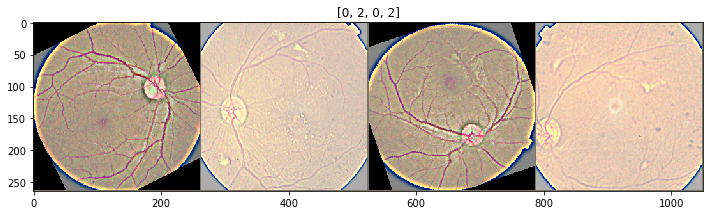

In [20]:

example_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4)


class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

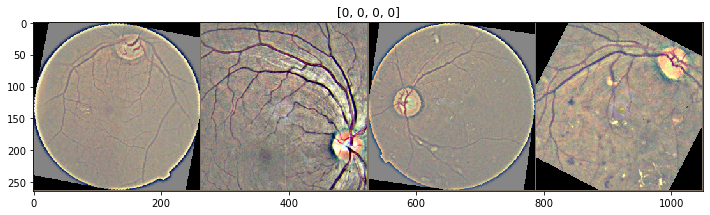

In [10]:
example_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=4)

class_names = [0,1,2,3,4]
# Get a batch of training data
inputs, classes = next(iter(example_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Pretrain Old Data

In [24]:
device = torch.device("cuda:0")
torch.cuda.is_available()


model =  EfficientNet.from_pretrained(enet) 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.cuda()



Loaded pretrained weights for efficientnet-b2


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [25]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [29]:
def train_model_old(epoch):
    model.train() 
        
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader_old):
        labels = labels.view(-1, 1) 
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        #loss.backward()
        optimizer.step() 
        optimizer.zero_grad() 
        avg_loss += loss.item() / len(train_loader_old)
        
    return avg_loss

def test_model_old():
    
    avg_val_loss = 0.
    model.eval()
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader_old):
            labels = labels.view(-1, 1) 
            imgs_vaild, labels_vaild = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_vaild)
            avg_val_loss += criterion(output_test, labels_vaild).item() / len(val_loader_old)
        
    return avg_val_loss

In [30]:
best_avg_loss = 100.0
n_epochs_old = 10

for epoch in range(n_epochs_old):
    
    print('lr:', scheduler.get_lr()[0])
    start_time   = time.time()
    avg_loss     = train_model_old(n_epochs_old)
    avg_val_loss = test_model_old()
    elapsed_time = time.time() - start_time
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs_old, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    scheduler.step()

lr: 0.001
Epoch 1/10 	 loss=0.5089 	 val_loss=0.4891 	 time=864.30s
lr: 0.001
Epoch 2/10 	 loss=0.4832 	 val_loss=0.4475 	 time=866.04s
lr: 0.001
Epoch 3/10 	 loss=0.4608 	 val_loss=0.4253 	 time=866.18s
lr: 0.001
Epoch 4/10 	 loss=0.4496 	 val_loss=0.4060 	 time=866.47s
lr: 1e-05
Epoch 5/10 	 loss=0.3842 	 val_loss=0.3684 	 time=868.17s
lr: 0.0001


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multipr

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/qile/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


### Define Model

In [31]:
device = torch.device("cuda:0")
torch.cuda.is_available()


model =  EfficientNet.from_pretrained(enet) 
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_name))
model.cuda()


Loaded pretrained weights for efficientnet-b2


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

### Loss function and optimizor

In [32]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

### Training

In [33]:
best_avg_loss = 100.0


for epoch in range(n_epochs):
    
    print('lr:', scheduler.get_lr()[0])
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, elapsed_time))
    
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    scheduler.step()

lr: 0.001
Epoch 1/25 	 loss=0.3962 	 val_loss=0.3391 	 time=351.19s
lr: 0.001
Epoch 2/25 	 loss=0.3107 	 val_loss=0.2805 	 time=351.01s
lr: 0.001
Epoch 3/25 	 loss=0.3186 	 val_loss=0.2746 	 time=349.06s
lr: 0.001
Epoch 4/25 	 loss=0.3006 	 val_loss=0.2602 	 time=353.75s
lr: 0.001
Epoch 5/25 	 loss=0.2749 	 val_loss=0.2721 	 time=353.75s
lr: 1e-05
Epoch 6/25 	 loss=0.2552 	 val_loss=0.2646 	 time=354.79s
lr: 0.0001
Epoch 7/25 	 loss=0.2391 	 val_loss=0.2655 	 time=354.56s
lr: 0.0001
Epoch 8/25 	 loss=0.2363 	 val_loss=0.2595 	 time=355.88s
lr: 0.0001
Epoch 9/25 	 loss=0.2351 	 val_loss=0.2457 	 time=354.16s
lr: 0.0001
Epoch 10/25 	 loss=0.2215 	 val_loss=0.2583 	 time=354.05s
lr: 1.0000000000000002e-06
Epoch 11/25 	 loss=0.2194 	 val_loss=0.2552 	 time=353.60s
lr: 1e-05
Epoch 12/25 	 loss=0.2105 	 val_loss=0.2588 	 time=352.51s
lr: 1e-05
Epoch 13/25 	 loss=0.2119 	 val_loss=0.2386 	 time=356.93s
lr: 1e-05
Epoch 14/25 	 loss=0.2118 	 val_loss=0.2558 	 time=351.99s
lr: 1e-05
Epoch 15/25 

In [ ]:
# effi B0  Epoch 15/20 	 loss=0.2432 	 val_loss=0.2899 	 time=120.21s
# effi B0 greenonly gamma correction   Epoch 8/20 	 loss=0.2640 	 val_loss=0.2800 	 time=127.31s
# effi B3 greenonly gamma correction rotaion Epoch 15/20 	 loss=0.1973 	 val_loss=0.2289 	 time=126.98s  "model/b3_clahe_g_gamma.bin"
# effi B3 greenonly gamma correction rotaion AMP Epoch 19/20 	 loss=0.1855 	 val_loss=0.2305 	 time=163.35s

## Validation Kappa Score

In [34]:
model = EfficientNet.from_name(enet)
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_name))
model.cuda()

for param in model.parameters():
    param.requires_grad = False
    
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [35]:
from sklearn import metrics

val_pred = np.zeros((len(val_df), 1))



for i, data in tqdm(enumerate(val_loader)):
    images, labels = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    val_pred[i * BS:(i + 1) * BS] += outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)


coef = [0.5, 1.5, 2.5, 3.5]

for i, pred in enumerate(val_pred):
    if pred < coef[0]:
        val_pred[i] = 0
    elif pred >= coef[0] and pred < coef[1]:
        val_pred[i] = 1
    elif pred >= coef[1] and pred < coef[2]:
        val_pred[i] = 2
    elif pred >= coef[2] and pred < coef[3]:
        val_pred[i] = 3
    else:
        val_pred[i] = 4
        
val_df['pred'] = val_pred

metrics.cohen_kappa_score(val_df['diagnosis'], val_df['pred'], weights='quadratic')

/home/qile/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9076197625278385

In [36]:
pd.pivot_table(val_df,columns='pred',values='id_code',index='diagnosis',aggfunc='count').fillna(0)

pred,0.0,1.0,2.0,3.0,4.0
diagnosis,,,,,
0,256.0,4.0,0.0,0.0,0.0
1,1.0,23.0,27.0,1.0,0.0
2,0.0,15.0,118.0,36.0,1.0
3,0.0,0.0,8.0,14.0,8.0
4,0.0,0.0,11.0,11.0,16.0


In [37]:
pd.pivot_table(val_df,columns='pred',values='id_code',index='diagnosis',aggfunc='count').fillna(0)

pred,0.0,1.0,2.0,3.0,4.0
diagnosis,,,,,
0,256.0,4.0,0.0,0.0,0.0
1,1.0,23.0,27.0,1.0,0.0
2,0.0,15.0,118.0,36.0,1.0
3,0.0,0.0,8.0,14.0,8.0
4,0.0,0.0,11.0,11.0,16.0


## Optimised the Kappa

In [38]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']


In [39]:
from functools import partial
import scipy as sp

for i, data in tqdm(enumerate(val_loader)):
    images, labels = data
    images = images.to(device, dtype=torch.float)
    outputs = model(images) 
    val_pred[i * BS:(i + 1) * BS] = outputs.detach().cpu().squeeze().numpy().reshape(-1, 1)

        
val_df['pred'] = val_pred
    
optR = OptimizedRounder()
valid_predictions = optR.fit(val_df['pred'], val_df['diagnosis'])
coefficients = optR.coefficients()
coefficients

/home/qile/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


array([0.51114902, 1.4533247 , 2.59416676, 3.46693649])

In [40]:
valid_predictions = optR.predict(val_df['pred'], coefficients)
metrics.cohen_kappa_score(val_df['diagnosis'], valid_predictions, weights='quadratic')

0.9184589684694091